In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [2]:
def compute_pca(X):
    """Compute PCA and return all eigenvalues and eigenvectors."""
    mean_val = np.mean(X, axis=0)
    X_centered = X - mean_val
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigen_values)[::-1]  # Sort in descending order
    return mean_val, eigen_values[sorted_indices], eigen_vectors[:, sorted_indices]

def apply_pca(X, k, mean_val, eigen_vectors):
    """Project dataset X onto the first k principal components."""
    top_k_eigen_vectors = eigen_vectors[:, :k]  # Select top k eigenvectors
    X_reduced = (X - mean_val) @ top_k_eigen_vectors  # Project onto top k PCs
    return X_reduced

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

mnist_train = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Convert dataset to numpy arrays
train_images = torch.stack([mnist_train[i][0] for i in range(len(mnist_train))]).numpy()
train_labels = np.array([mnist_train[i][1] for i in range(len(mnist_train))])

test_images = torch.stack([mnist_test[i][0] for i in range(len(mnist_test))]).numpy()
test_labels = np.array([mnist_test[i][1] for i in range(len(mnist_test))])

In [4]:
train_images_sampled, _, train_labels_sampled, _ = train_test_split(
    train_images, train_labels, train_size=1000, stratify=train_labels, random_state=42
)

In [5]:
k_values = [500, 300, 150, 30]
# Compute PCA once
mean_val, eigen_values, eigen_vectors = compute_pca(train_images_sampled)

# ---- Projection of 1000 samples onto k dimensions ----
pca_projections = {k: apply_pca(train_images_sampled, k, mean_val, eigen_vectors) for k in k_values}

# Print shape of projected data
for k, X_proj in pca_projections.items():
    print(f"Projected dataset shape with k={k}: {X_proj.shape}")

Projected dataset shape with k=500: (1000, 500)
Projected dataset shape with k=300: (1000, 300)
Projected dataset shape with k=150: (1000, 150)
Projected dataset shape with k=30: (1000, 30)


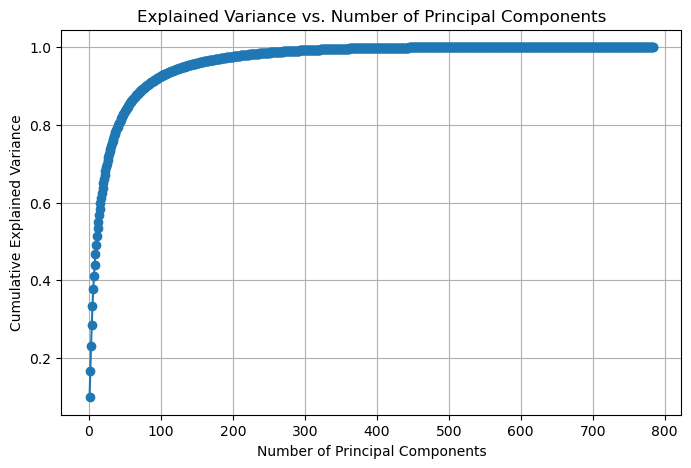

In [6]:
explained_variance_ratio = eigen_values / np.sum(eigen_values)
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Principal Components")
plt.grid()
plt.show()

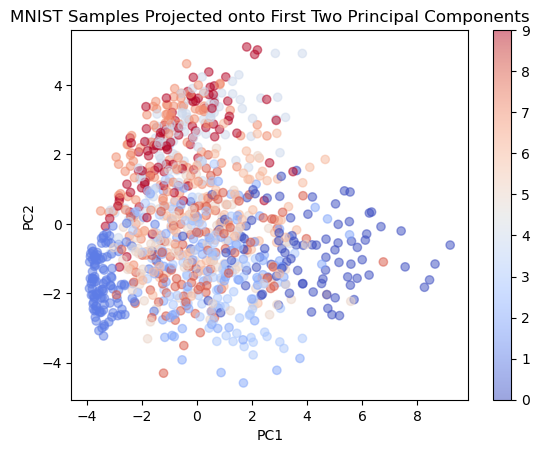

In [7]:
top_2_eigen_vectors = eigen_vectors[:, :2]
X_projected = (train_images_sampled - mean_val) @ top_2_eigen_vectors
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=train_labels_sampled, cmap='coolwarm', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("MNIST Samples Projected onto First Two Principal Components")
plt.colorbar()
plt.show()

Observations :
1. The digits appear to form distinct clusters, though some overlap exists.
2. Digits with similar shapes, such as 8 and 9 (reddish regions) or 0 and 6 (bluish regions), are positioned closely.
3. Some digits blend into one another, especially in the center of the plot.
4. This suggests that the first two principal components do not fully separate all digits, and more dimensions might be needed for better separation.
5. The data is spread out more in certain directions, indicating that some digits have higher variance along these components.
6. Digits like 1 (light blue) seem more concentrated in a particular region, while digits like 8 and 9 (reddish) are more dispersed.

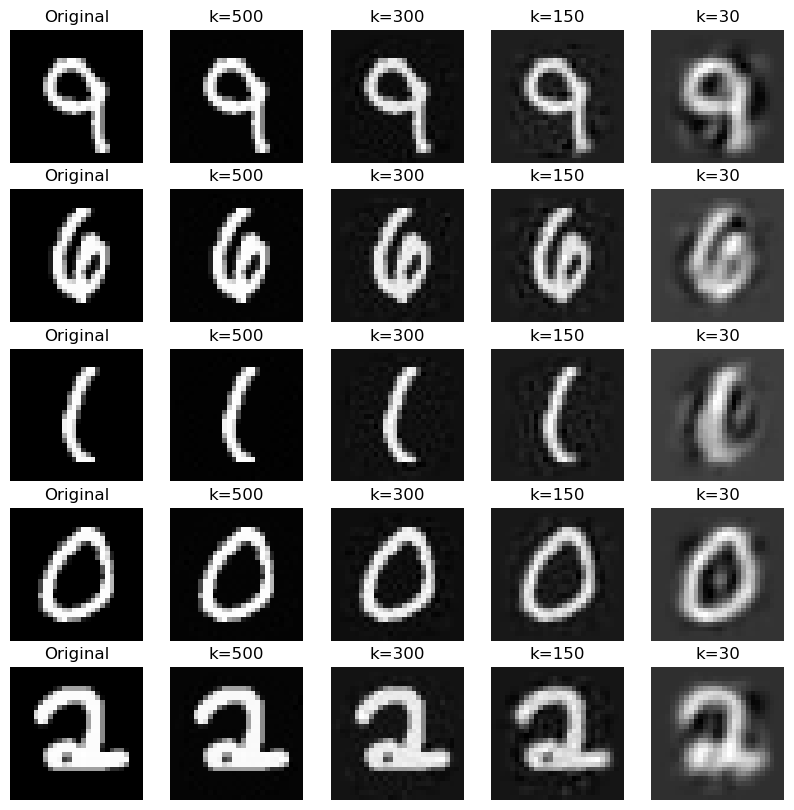

In [28]:
sampled_images = train_images_sampled[:5]

fig, axes = plt.subplots(5, len(k_values) + 1, figsize=(10, 10))

for i in range(5):
    axes[i, 0].imshow(sampled_images[i].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    for j, k in enumerate(k_values):
        top_k_eigen_vectors = eigen_vectors[:, :k]  # Select top k eigenvectors
        X_reduced = (sampled_images - mean_val) @ top_k_eigen_vectors  # Reduce only 5 images
        X_reconstructed = X_reduced @ top_k_eigen_vectors.T + mean_val  # Reconstruct
        axes[i, j + 1].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[i, j + 1].set_title(f"k={k}")
        axes[i, j + 1].axis("off")

plt.show()

Observations : 
1. Dimension 500 : The reconstruction looks almost identical to the original, as PCA with a large number of components captures most of the original data's information.
2. Dimension 300 : There is not much difference between image of 500, 300, it suggests that dimension 300 can be used instead of 500 in many cases for computational efficiency. The image is still largely recognizable, with most major structures intact.
3. Dimension 150 : At this level of reduction, there is loss of significant amount of detail, which made the image look blurrier or less defined, though it still retains the general form and structure.
4. Dimension 30 : With only 30 components, most of the information from the original image is discarded, and the image became a low-resolution approximation of the original. Major features like the general shapes are visible, but fine details are absent.

In [29]:
train_images_sampled, _, train_labels_sampled, _ = train_test_split(
    train_images, train_labels, train_size=40000, stratify=train_labels, random_state=42
)

# Train MLP without PCA
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), activation='relu', solver='adam', max_iter=50, random_state=42)
mlp.fit(train_images_sampled, train_labels_sampled)
test_preds = mlp.predict(test_images)

# Compute Metrics
print("Without PCA:")
print(f"Accuracy: {accuracy_score(test_labels, test_preds):.4f}")
print(f"Precision: {precision_score(test_labels, test_preds, average='macro'):.4f}")
print(f"Recall: {recall_score(test_labels, test_preds, average='macro'):.4f}")

# Train MLP with PCA for different k values
mean_val, eigen_values, eigen_vectors = compute_pca(train_images_sampled)

for k in k_values:
    top_k_eigen_vectors = eigen_vectors[:, :k]
    X_train_reduced = (train_images_sampled - mean_val) @ top_k_eigen_vectors
    X_test_reduced = (test_images - mean_val) @ top_k_eigen_vectors
    
    mlp.fit(X_train_reduced, train_labels_sampled)
    test_preds = mlp.predict(X_test_reduced)
    
    print(f"With PCA (k={k}):")
    print(f"Accuracy: {accuracy_score(test_labels, test_preds):.4f}")
    print(f"Precision: {precision_score(test_labels, test_preds, average='macro'):.4f}")
    print(f"Recall: {recall_score(test_labels, test_preds, average='macro'):.4f}")

Without PCA:
Accuracy: 0.9808
Precision: 0.9807
Recall: 0.9807
With PCA (k=500):
Accuracy: 0.9728
Precision: 0.9726
Recall: 0.9726
With PCA (k=300):
Accuracy: 0.9752
Precision: 0.9751
Recall: 0.9751
With PCA (k=150):
Accuracy: 0.9780
Precision: 0.9780
Recall: 0.9778
With PCA (k=30):
Accuracy: 0.9791
Precision: 0.9790
Recall: 0.9789


Without PCA:
Observation: The model achieves the highest performance without dimensionality reduction. The accuracy, precision, and recall are all very high, indicating that the model is performing well on the original feature space. This suggests that the features in the original dataset provide sufficient information for the classifier to make accurate predictions.
With PCA (k=500):
Observation: After applying PCA with 500 components, there is a noticeable decrease in performance compared to the original model (no PCA). This reduction in performance indicates that although 500 components retain a significant amount of the original variance, some important information is still lost during dimensionality reduction. While the drop is not drastic, it shows that reducing dimensions does come with a performance trade-off.
With PCA (k=300):
Observation: Reducing the number of components further to 300 results in a slight improvement in performance compared to 500 components. The accuracy, precision, and recall values are still lower than the original model (without PCA), but the reduction in performance is relatively moderate. This suggests that the PCA with 300 components retains a significant amount of information but still introduces some loss in classification performance.
With PCA (k=150):
Observation: When reducing to 150 components, the performance remains relatively high and close to the original model. However, there is a slight drop in accuracy, precision, and recall compared to the non-PCA model. This shows that while dimensionality reduction with 150 components still allows the model to perform well, it may be losing some finer details and complexity present in the original data.
With PCA (k=30):
Observation: With just 30 components, the performance is almost as good as the original model. The drop in performance compared to the non-PCA model is minimal, suggesting that a significant amount of the useful information can still be retained even with a much smaller feature set. This indicates that the dimensionality reduction with PCA to 30 components is highly efficient and preserves the key aspects of the data needed for the classifier to make accurate predictions.

Effect of Different k Values:

At k=500 and k=300, performance is noticeably worse than the original model without PCA.
At k=150 and k=30, the decrease in performance is minimal, suggesting that these lower dimensions still capture most of the relevant information for the task at hand.

Question : How does PCA help mitigate the curse of dimensionality? Can you think
of cases where PCA might not be effective in high-dimensional spaces?


PCA and the Curse of Dimensionality:
PCA mitigates the curse of dimensionality by reducing the number of features while preserving most of the data's variance. This makes computations more efficient and reduces the risk of overfitting, which is common in high-dimensional spaces where data points become sparse.

When PCA Might Not Be Effective:

Non-linear Data: PCA assumes linear relationships between features, so it may not capture important non-linear patterns in the data.
Noise Dominance: If the high-dimensional space is mostly noise, PCA may still retain irrelevant components, leading to poor performance.
Outliers: PCA is sensitive to outliers, which can distort the principal components and reduce its effectiveness in certain cases.

Question : PCA assumes that the directions of maximum variance are the most infor-
mative. Is this always true? Provide an example where this assumption
might fail.

No, the assumption that the directions of maximum variance are the most informative is not always true.

Example where this assumption might fail:

Classification Problems with Imbalanced Data: In a classification problem where one class is highly underrepresented (imbalanced classes), PCA might prioritize the variance in the dominant class. This could cause the principal components to reflect variations that are not useful for distinguishing between classes. For instance, if the majority class dominates the variance, PCA may focus on these variations rather than the features that separate the minority class, which could be more informative for classification.
Thus, in such cases, PCA might fail to capture the most relevant features for the task at hand, especially if the most informative directions are associated with lower variance rather than higher variance.